In [1]:
import sys
sys.path.insert(0, '/camp/home/maizelr/working/Rory/python_scripts')
from simple_velocity import *
from utils import *

import_my_tools()

/camp/home/maizelr/.local/lib/python3.8/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}



        # base packages
        import sys
        import pandas as pd
        import numpy as np
        import scipy as sp      
        import matplotlib.pyplot as plt
        import pickle
        import seaborn as sns
        import pickle
        import adjustText

        # velocity packages
        import scanpy as sc
        import scvelo as scv
        import anndata as ann
        import dynamo as dyn
        import cellrank as cr

        # extra packages
        import plotly as pl
        import plotly.graph_objects as go
        import plotly.express as px
        import ipywidgets as ipy
        


In [2]:
import cellrank as cr

In [3]:
hdata_0 = load_human_velocity()

Loading:  /camp/home/maizelr/working/Rory/transcriptomics/human_transcriptomics_analysis/data/new_human_velocity_20210121.loom
Variable names made unique.


In [22]:
hdata_0.var['mt'] = hdata_0.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(hdata_0, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [23]:
hdata = hdata_0.copy()
sc.pp.normalize_total(hdata, target_sum=1e4)
sc.pp.log1p(hdata)
hdata.strings_to_categoricals()

In [5]:
def temporal_BROV_genes(data, species, n=2000):
    """ temporally stratified biologically relevant or variable genes"""
    gene_sets = []
    for time in data.obs.timepoint.unique():
        copy = data.copy()
        copy = copy[copy.obs.timepoint==time]
        scv.pp.filter_genes_dispersion(copy, n_top_genes=n)
        tp_genes = copy.var_names  
        gene_sets.append(tp_genes)
    hv_genes = set(gene_sets[0]).intersection(*gene_sets[1:])
    print("HV ",len(hv_genes))
    br_genes = gene_list('nt', species=species)
    print("BR ",len(br_genes))
    genes = list(set(hv_genes).union(set(br_genes)))
    genes = list(set(genes).intersection(set(data.var_names)))
    return genes

In [6]:
def run_dynamics(adata, species, domain, weight, terminal, initial):
    print("Processing {0}...".format(domain))
    dom_data = adata[adata.obs.domain==domain]
    'Selecting Genes...'
    dom_genes = temporal_BROV_genes(dom_data, species, n=2000)
    print('{0} Genes Total.'.format(len(dom_genes)))
    dom_data = dom_data[:,dom_genes]
    scv.pp.moments(dom_data, n_pcs=30, n_neighbors=30)
    scv.tl.recover_dynamics(dom_data)
    scv.tl.velocity(dom_data, mode='stochastic')
    scv.tl.velocity_graph(dom_data)
    scv.tl.velocity_embedding(dom_data, basis='pca')
    scv.tl.latent_time(dom_data)
    sc.tl.rank_genes_groups(dom_data, groupby='cell_type', n_genes=8)
    cr.tl.terminal_states(dom_data, cluster_key='cell_type', weight_connectivities=weight, n_states=terminal);
    cr.tl.initial_states(dom_data, cluster_key='cell_type', n_states=initial)
    cr.tl.lineages(dom_data)
    scv.tl.recover_latent_time(dom_data, root_key='initial_states_probs', end_key='terminal_states_probs')
    fig = plt.figure(figsize=(36,16))
    (ax1, ax2, ax3), (ax4, ax5, ax6)  = fig.subplots(nrows=2, ncols=3)
    scv.pl.velocity_embedding_stream(dom_data, color=['cell_subtype'],
                                     basis='pca', legend_fontsize=22, title=[f'{domain} PCA: Cell Type'], 
                                     smooth=.8, min_mass=4, figsize=(12,8), fontsize=22, dpi=400, ax=ax1, show=False)
    scv.pl.velocity_embedding_stream(dom_data, color=['timepoint'], color_map='gnuplot',
                                     basis='pca', legend_fontsize=12, title=['B. PCA: Timepoint'], 
                                     smooth=.8, min_mass=4, figsize=(12,8), fontsize=22, dpi=400, ax=ax2, show=False)
    scv.pl.velocity_embedding_stream(dom_data, color=['latent_time'],color_map='viridis',
                                     basis='pca', legend_fontsize=12, title=['C. PCA: Latent Time'], 
                                     smooth=.8, min_mass=4, figsize=(12,8), fontsize=22, dpi=400, ax=ax3, show=False)
    cr.pl.terminal_states(dom_data, discrete=True, title='D. Predicted Terminal States', dpi=400,
                          fontsize=22, figsize=(12,8), legend_fontsize=22, size=500, ax=ax4, show=False)
    cr.pl.lineages(dom_data, same_plot=True, show=False, fontsize=22, ax=ax5, dpi=400, title='Lineages')
    cr.pl.initial_states(dom_data, discrete=True, title='F. Predicted Initial State (One Enforced)', dpi=400,
                          fontsize=22, figsize=(12,8), legend_fontsize=22, size=500, ax=ax6, show=False)
    plt.show()
    return dom_data

<Figure size 864x216 with 0 Axes>

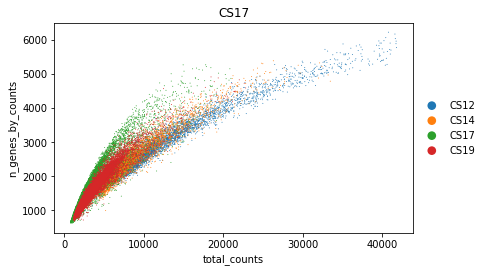

In [17]:
fig = plt.figure(figsize=(12,3))
sc.pl.scatter(hdata_0, color='timepoint', x='total_counts', y='n_genes_by_counts', title='CS17')


In [51]:
dom_data = hdata[hdata.obs.domain=='MN']
dom_genes = temporal_BROV_genes(dom_data, 'human', n=2000)
dom_data = dom_data[:,dom_genes]
scv.pp.moments(dom_data, n_pcs=30, n_neighbors=30)
scv.tl.recover_dynamics(dom_data)
scv.tl.velocity(dom_data, mode='stochastic')
scv.tl.velocity_graph(dom_data)
scv.tl.velocity_embedding(dom_data, basis='pca')

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Exctracted 2000 highly variable genes.


Trying to set attribute `.obs` of view, copying.


Exctracted 2000 highly variable genes.


Trying to set attribute `.obs` of view, copying.


Exctracted 2000 highly variable genes.
Exctracted 2000 highly variable genes.
HV  106
BR  177
Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics
    finished (0:01:04) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


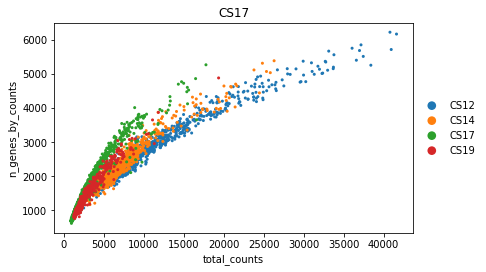

In [25]:
sc.pl.scatter(dom_data, color='timepoint', x='total_counts', y='n_genes_by_counts', title='CS17')


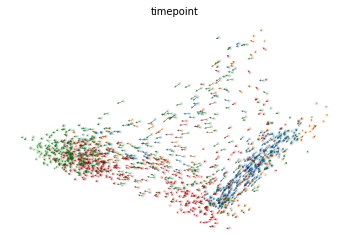

In [50]:
# plot_pca_contributions(dom_data, color='timepoint', n=10)

scv.pl.velocity_embedding(dom_data, basis='pca', color='timepoint', arrow_length=3)

In [52]:
dom_data2 = hdata[hdata.obs.domain=='V2']
dom_genes2 = temporal_BROV_genes(dom_data2, 'human', n=2000)
dom_data2 = dom_data2[:,dom_genes2]
scv.pp.moments(dom_data2, n_pcs=30, n_neighbors=30)
scv.tl.recover_dynamics(dom_data2)
scv.tl.velocity(dom_data2, mode='stochastic')
scv.tl.velocity_graph(dom_data2)
scv.tl.velocity_embedding(dom_data2, basis='pca')

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Exctracted 2000 highly variable genes.


Trying to set attribute `.obs` of view, copying.


Exctracted 2000 highly variable genes.


Trying to set attribute `.obs` of view, copying.


Exctracted 2000 highly variable genes.
Exctracted 2005 highly variable genes.
HV  173
BR  177
Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics
    finished (0:00:51) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


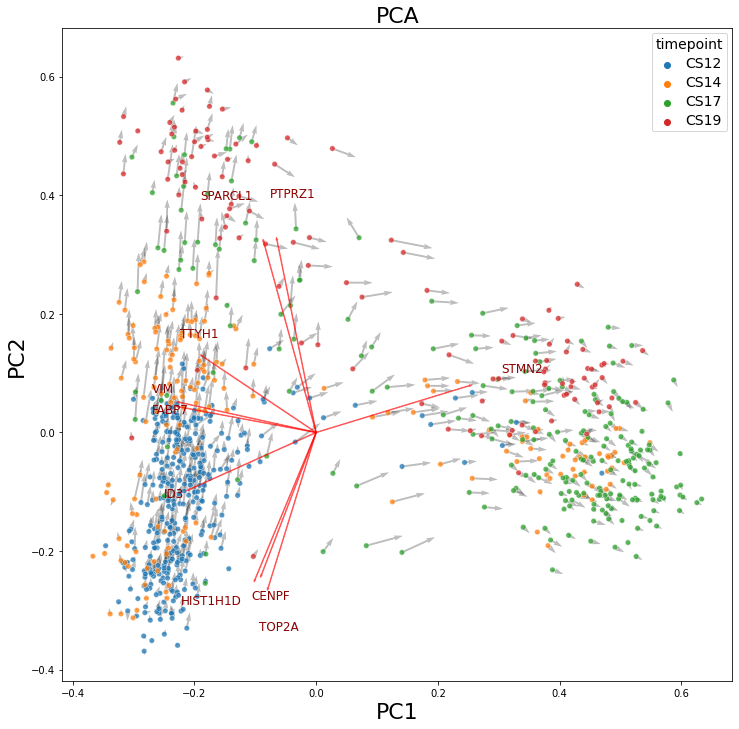

In [47]:
plot_pca_contributions(dom_data2, color='timepoint', n=10)

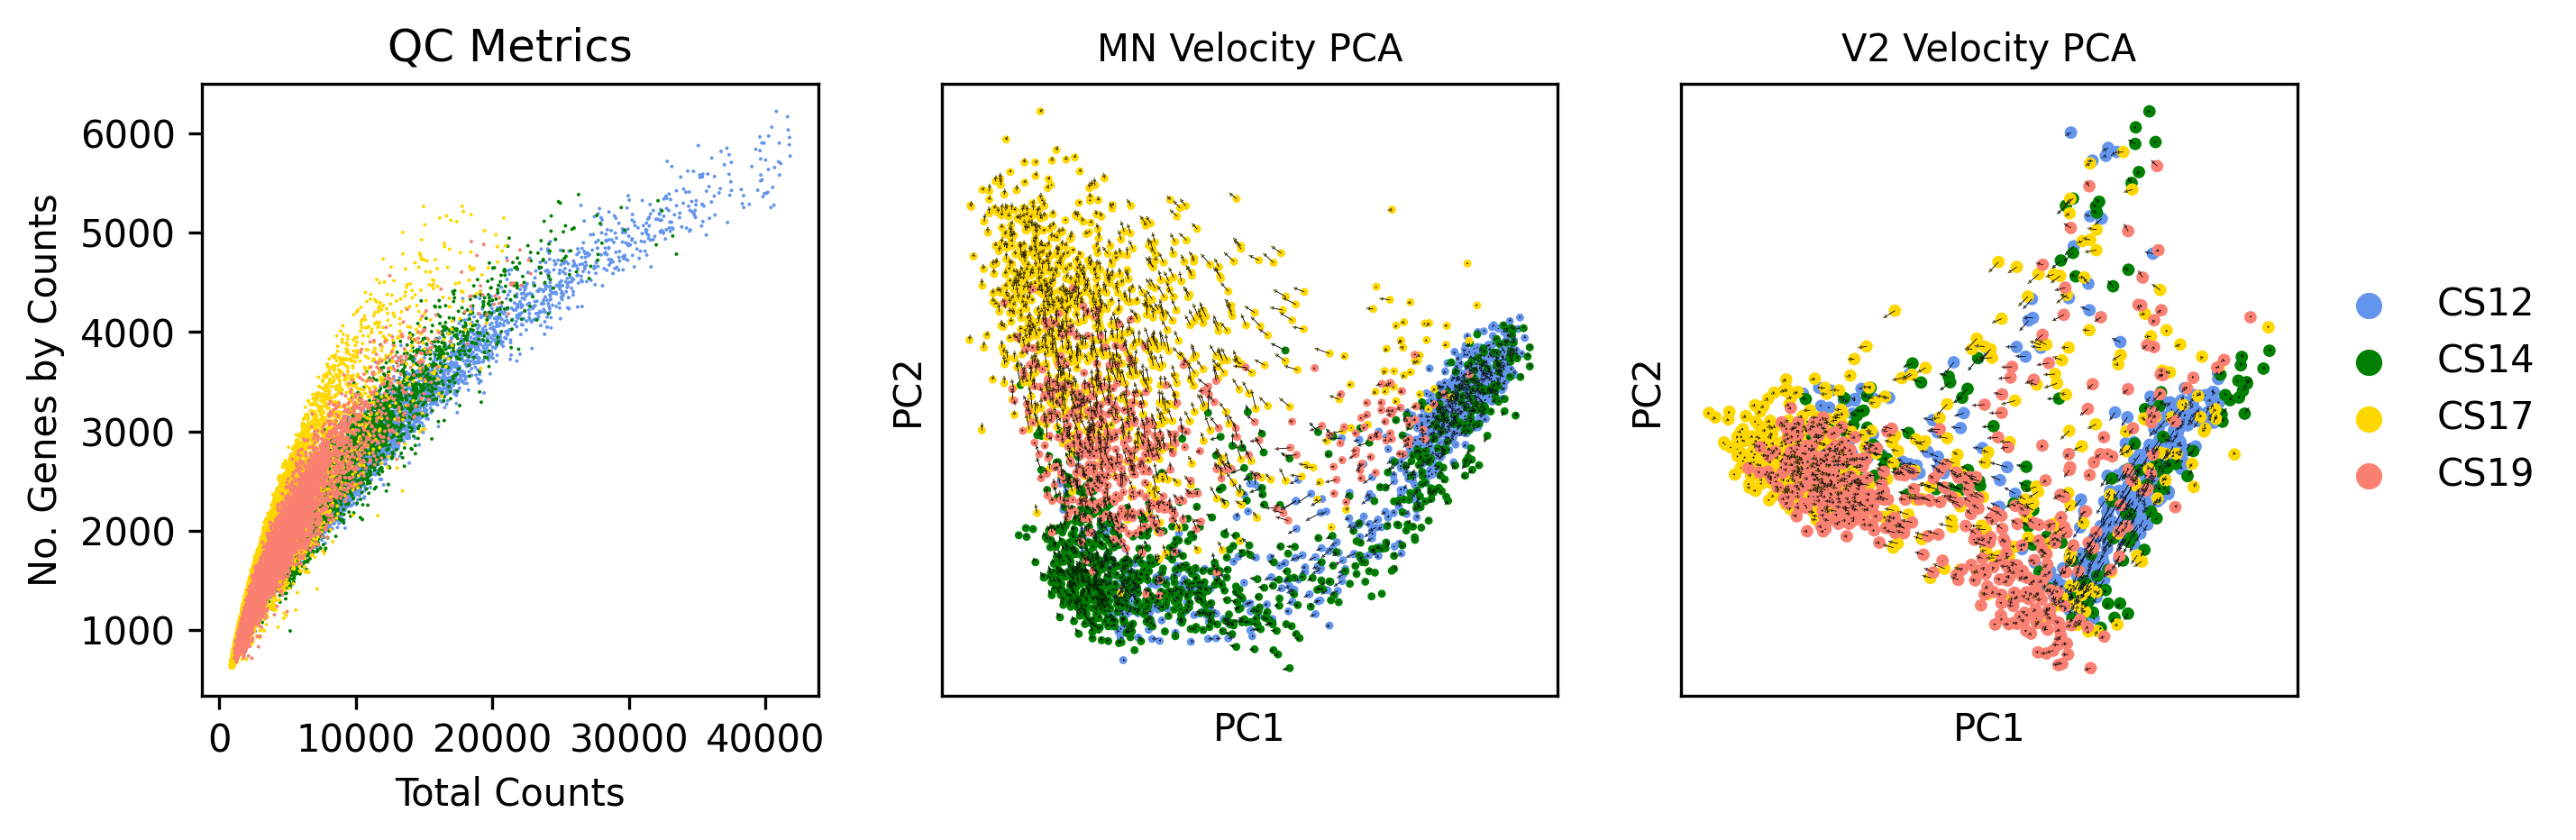

In [64]:
fig = plt.figure(figsize=(10,3), dpi=300)
(ax1, ax2, ax3) = fig.subplots(1,3)
palette= ['cornflowerblue','green','gold','salmon']
sc.pl.scatter(hdata_0, color='timepoint', x='total_counts', y='n_genes_by_counts', title='QC Metrics', palette=palette, ax=ax1, legend_loc='none', show=False)
ax1.set_xlabel('Total Counts')
ax1.set_ylabel('No. Genes by Counts')
scv.pl.velocity_embedding(dom_data, basis='pca', color='timepoint', arrow_length=3, ax=ax2, show=False, frameon=True, title='MN Velocity PCA', palette=palette, legend_loc='none', alpha=1)
scv.pl.velocity_embedding(dom_data2, basis='pca', color='timepoint', arrow_length=3, ax=ax3, show=False, frameon=True, title='V2 Velocity PCA', palette=palette, legend_loc='right margin', alpha=1)
plt.savefig('../plots/8_CS17_QC_plot.png')